# Enabling Observability with OpenTelemetry

Atoti Python API features an observability plugin to integrate OpenTelemetry with Atoti for better monitoring and debugging capabilities. 

In this notebook, we’ll explore how to set up observability for Atoti Python API using OpenTelemetry.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=observability-with-otel" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

In [1]:
# !uv pip install 'atoti[observability]'

In [2]:
import atoti as tt
import zipfile
import wget
from IPython.display import clear_output, display

## Start the OTEL stack

To set up observability for Atoti using OpenTelemetry, we'll need a place to send our metrics, logs, and traces that can process and visualize our telemetry data.

The `docker-compose.yaml` located in `otel-stack` configures the following multi-container [Docker](https://www.docker.com/) application:

![otel-stack-diagram](https://data.atoti.io/notebooks/observability-with-otel/img/otel-stack-diagram.png)

With the Atoti Python API observability plugin, Atoti can use OpenTelemetry to instrument its code and generate telemetry data during execution, which is then handled by the [OTEL collector](https://opentelemetry.io/docs/collector/)  and sent to the corresponding services integrated with [Grafana](https://grafana.com/):

* **Traces:** Exported to [Tempo](https://grafana.com/oss/tempo/) (with OTLP).
* **Logs:** Exported to [Loki](https://grafana.com/oss/loki/) (push to an endpoint).
* **Metrics:** Scraped from the OTEL collector endpoint via [Prometheus](https://grafana.com/oss/prometheus/) every 15 seconds.

Navigate to `otel-stack` and execute the following command to setup and confirm the containers are up and running:

```bash
docker compose up -d
```

💡 **Note:** Use the `docker ps` and `docker logs` commands to verify the containers are healthy and also diagnose issues if they arise, respectively.


## Download data

To simulate greater computation in this walk through, we've prepared 2GB worth of trades and books data.

In [3]:
url = f"https://data.atoti.io/notebooks/observability-with-otel/data/data.zip"
filename = wget.download(url)

with zipfile.ZipFile(filename, "r") as zip_ref:
    zip_ref.extractall()

100% [......................................................................] 843205063 / 843205063

## Configure the Atoti session for OpenTelemetry

When using the observability plugin for Atoti Python API, we'll need to configure the underlying Atoti Server JVM to use OpenTelemetry. 

The following configurations are set as their defaults:

```java
"-Dspring.profiles.active=application-monitoring",
"-Dotel.java.global-autoconfigure.enabled=true",
"-Dotel.traces.exporter=otlp",
"-Dotel.metrics.exporter=otlp",
"-Dotel.logs.exporter=otlp",
"-Dotel.exporter.otlp.endpoint=http://localhost:4318",
"-Dotel.resource.attributes=service.name=atoti,service.version=1.0",
```

The following configurations are user specific:

```java
"-Djson.log.dir=logs",
"-Dotel.traces.sampler=always_on",
"-Dotel.metric.export.interval=1000",

```
    
We can also add in an OpenTelemetry java agent to report more metrics about the performance of the underlying JVM.

```java
"-javaagent:opentelemetry-javaagent.jar"
```


In [4]:
url = f"https://github.com/open-telemetry/opentelemetry-java-instrumentation/releases/latest/download/opentelemetry-javaagent.jar"
filename = wget.download(url)

100% [........................................................................] 21917654 / 21917654

In [5]:
session = tt.Session.start(
    tt.SessionConfig(
        port=9105,
        java_options=[
            "-Dspring.profiles.active=application-monitoring",
            "-Dotel.java.global-autoconfigure.enabled=true",
            "-Dotel.traces.exporter=otlp",
            "-Dotel.metrics.exporter=otlp",
            "-Dotel.logs.exporter=otlp",
            "-Dotel.exporter.otlp.endpoint=http://localhost:4318",
            "-Dotel.resource.attributes=service.name=atoti,service.version=1.0",
            "-Djson.log.dir=logs",
            "-Dotel.traces.sampler=always_on",
            "-Dotel.metric.export.interval=1000",
            "-javaagent:opentelemetry-javaagent.jar",
        ],
    )
)

## Load data, join data, visualize data model

We then load our data into tables, make the corresponding joins, and visualize the data model of the cube.

Trades Row Count: 383688
Books Row Count: 408


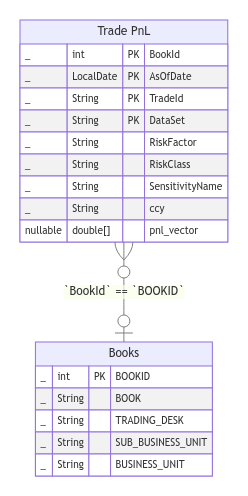

In [6]:
trades_tbl = session.read_csv(
    "data/trades/TradePnLs*.csv",
    table_name="Trade PnL",
    keys=["AsOfDate", "TradeId", "BookId", "DataSet"],
    array_separator=";",
)
books_tbl = session.read_csv(
    "data/books/books_books.csv", table_name="Books", keys=["BOOKID"]
)
trades_tbl.join(books_tbl, trades_tbl["BookId"] == books_tbl["BOOKID"])

cube = session.create_cube(trades_tbl)
h, l, m = cube.hierarchies, cube.levels, cube.measures

print(f"Trades Row Count: {trades_tbl.row_count}")
print(f"Books Row Count: {books_tbl.row_count}")

session.tables.schema

In [7]:
m

{'pnl_vector.SUM': <atoti.measure.Measure object at 0x137575110>, 'pnl_vector.MEAN': <atoti.measure.Measure object at 0x137cae0d0>, 'contributors.COUNT': <atoti.measure.Measure object at 0x1404dbfd0>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x1404d9350>}

### Computing VaR 95

We have a `pnl_vector.SUM` which is the sum of the profit and loss (PnL) value for each historical date. Therefore, we can define the formula for a 95% confidence level [value at risk (VaR)](https://www.investopedia.com/articles/04/092904.asp) measure as follows:

In [8]:
m["VaR95"] = tt.array.quantile(m["pnl_vector.SUM"], 1 - 0.95)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
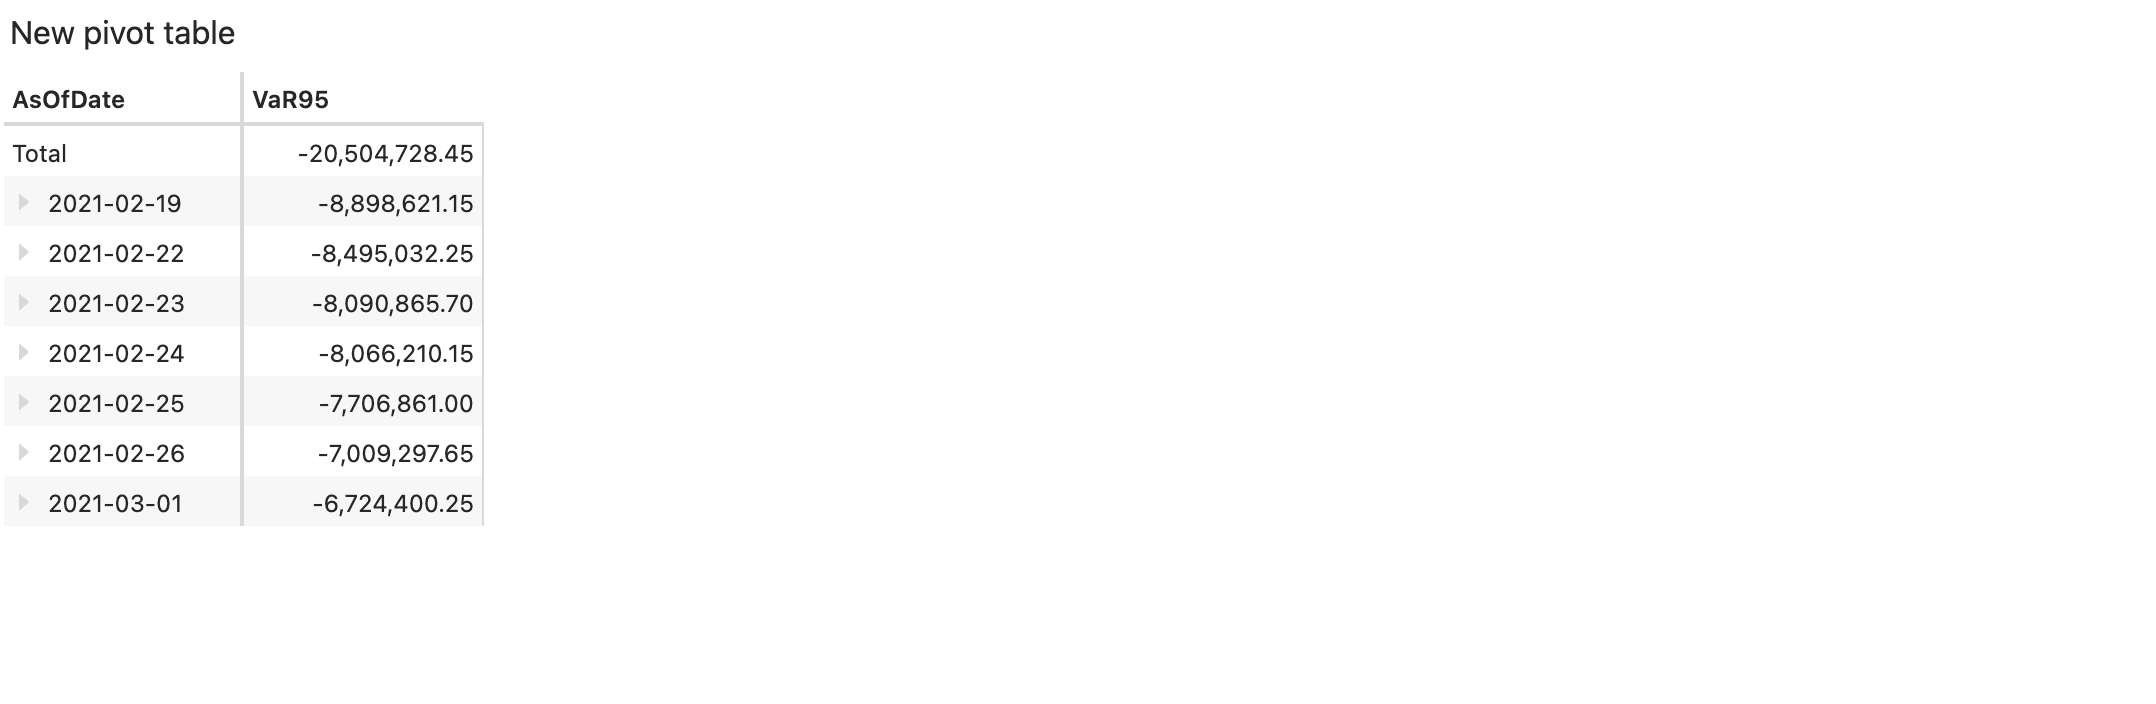

In [9]:
session.widget

## Monitoring Performance

By this point, Atoti will have already sent over telemetry data to the OpenTelemetry collector. This data can then be processed and visualized in Grafana using Loki, Tempo, and Prometheus.

### Metrics

Metrics are quantifiable measurements that reflect the behvaior, health, and performance of an application and its infrastructure.

Navigate to the Grafana UI located at [localhost:3000](http://localhost:3000) and click on the *Metrics* item in the left-hand pane to pull up the metric charts. By instrumenting Atoti code with OpenTelemetry using the observability plugin, we can genereate Atoti-specific metrics and visualize them in Grafana using Prometheus.

💡 **Note:** Check out the documentation for more information on [Atoti-specific metrics](https://docs.activeviam.com/products/atoti/server/6.1.0/docs/monitoring/metrics/).

![metrics](https://data.atoti.io/notebooks/observability-with-otel/img/metrics.png)

Similarly, we can also view the JVM metrics reported by the OpenTelemetry Java agent.

![java-metrics](https://data.atoti.io/notebooks/observability-with-otel/img/java-metrics.png)

## Logs

Logs are the detailed records of events, warnings and errors occurring over time for a software application or system. 

When we view the Atoti logs in Grafana using Loki, we see the underlying events performed in this notebook: starting the Atoti session, loading data from CSV, creating the cube, and most recently, querying the database using the Atoti JupyterLab widget shown in previous cells.

![logs](https://data.atoti.io/notebooks/observability-with-otel/img/logs.png)

## Traces

Traces are the detailed records of how a request flows through a system, tracking its journey across different components, services, or processes. Traces are critical for understanding the flow of requests and interactions within a system and are made of one or more spans.

If we select one of the logs relating to the `VaR95` query executed in previous cells, we can pinpoint its `TraceID`.

![logs-traceid](https://data.atoti.io/notebooks/observability-with-otel/img/logs-traceid.png)

With Grafana and Tempo, we visualize the flow of the `TraceID` and get a better understanding of the different components or services that were impacted when querying the Atoti database using the Atoti JupyterLab widget.

![traceid-spans](https://data.atoti.io/notebooks/observability-with-otel/img/traceid-spans.png)

## Monitoring aggregate providers

A common use case in Atoti is to use aggregate providers to speed up queries. Aggregate providers pre-compute and store aggregates for the specified granularity for certain hierarchies. These intermediate aggregates are then stored in-memory and used to improve query performance, though at the cost of a higher memory footprint.

💡 **Note:** Take a look at the [aggregate providers](../aggregate-provider/main.ipynb) notebook for a better understanding of how to use aggregate providers.

Let's use the observability plugin for Atoti Python API to monitor the creation and use of an aggregate provider. We'll use the `query` function with the `%%time` magic command to get a second opinion of how long it takes the query to return the results for the `VaR95` calculation at the specified granularity and slice of data.

In [10]:
%%time
cube.query(
    m["VaR95"],
    levels=[l["BUSINESS_UNIT"], l["SUB_BUSINESS_UNIT"], l["TRADING_DESK"]],
)

CPU times: user 23.7 ms, sys: 3.91 ms, total: 27.6 ms
Wall time: 149 ms


VaR95
BUSINESS_UNIT   SUB_BUSINESS_UNIT       TRADING_DESK                
Equity          Foreign Equity          Hermes        -15,683,021.95
Forex           Developed Market        Hades         -11,388,007.35
Rates & Credits Domestic Rates & Credit Hermes        -14,759,246.45
                                        Keres          -9,802,986.55

When we re-visit Grafana and Tempo and monitor the trace for the query, we can see the corresponding breakdown of spans for each of the underlying services that were impacted.

💡 **Note:** The time taken produced by `%%time` may differ from what is shown in the corresponding TraceID diagram. This is because `%%time` measures the execution time of the notebook cell entirely, whereas the TraceID measures the execution time of a request traveling through the system.

![before-aggregate-provider](https://data.atoti.io/notebooks/observability-with-otel/img/before-aggregate-provider.png)

Let's create our aggregate provider to match the granularity of the previous query for the `pnl_vector.SUM` measure, which is used as an intermediate aggregate when calculating `VaR95`.

In [11]:
cube.aggregate_providers.update(
    {
        "PnL provider": tt.AggregateProvider(
            key="bitmap",
            levels=[
                l["BUSINESS_UNIT"],
                l["SUB_BUSINESS_UNIT"],
                l["TRADING_DESK"],
            ],
            measures=[m["pnl_vector.SUM"]],
        )
    }
)

Then, re-run the query.

In [12]:
%%time
cube.query(
    m["VaR95"],
    levels=[l["BUSINESS_UNIT"], l["SUB_BUSINESS_UNIT"], l["TRADING_DESK"]],
)

CPU times: user 12 ms, sys: 4.98 ms, total: 17 ms
Wall time: 86.4 ms


VaR95
BUSINESS_UNIT   SUB_BUSINESS_UNIT       TRADING_DESK                
Equity          Foreign Equity          Hermes        -15,683,021.95
Forex           Developed Market        Hades         -11,388,007.35
Rates & Credits Domestic Rates & Credit Hermes        -14,759,246.45
                                        Keres          -9,802,986.55

Sure enough, the `%%time` magic command suggests that query times have improved thanks to the aggregate provider. In addition, when we view the corresponding TraceID in Grafana and Tempo, we can visualize the granular improvement for the request.

![after-aggregate-provider](https://data.atoti.io/notebooks/observability-with-otel/img/after-aggregate-provider.png)

This walk through was just a small example of how to get observability up and running with OpenTelemetry using the Atoti observability plugin. In production, the importance of performance tuning and monitoring will become more and more relevant as the Atoti application continues to scale.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=observability-with-otel" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>